In [34]:
import pandas as pd 

df = pd.read_csv('/Users/youweicheng/Desktop/Code/ML/RNN/archive/Alcohol_Sales.csv', index_col=0, parse_dates=True)

df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [35]:
df.isnull().sum()

S4248SM144NCEN    0
dtype: int64

In [36]:
len(df)

325

In [37]:
df = df.rename({'S4248SM144NCEN': 'Sales'}, axis=1)

In [38]:
df

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


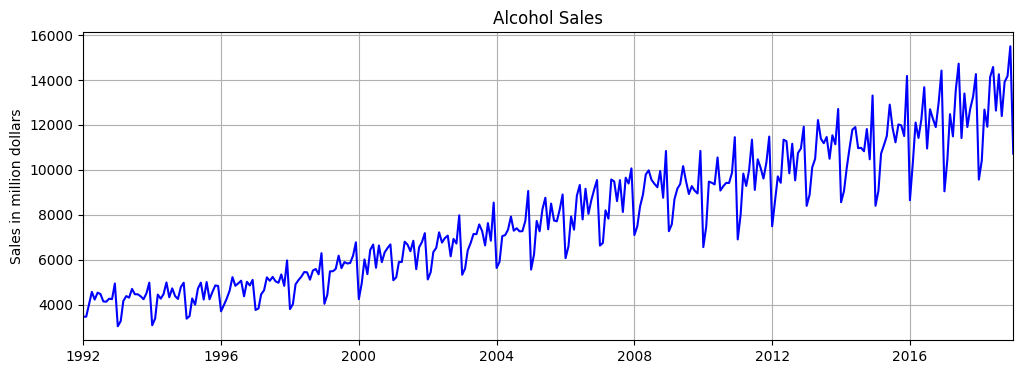

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis= 'x', tight=True)
plt.plot(df['Sales'], color='blue')
plt.show()

In [40]:
# Preparing the data

y = df['Sales'].values.astype(float)

test_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [46]:
# Normalise the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))



In [51]:
import torch
import torch.nn as nn
%matplotlib inline
# Prepare data for LSTM model
# convert train_norm to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

window_size = 12

def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i: i+ws]
        label = seq[i+ws: i+ws+1]
        out.append((window, label))
    return out

train_data = input_data(train_norm, window_size)
len(train_data)

301

In [53]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [54]:
# Modelling

class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # add an LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)

        # add a fully-connected layer
        self.linear = nn.Linear(hidden_size, output_size)

        # intitialising h0 and c0
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden
        )
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]

In [56]:
# Instantiation, loss and optimiser

torch.manual_seed(36)

# instantiate
model = LSTMnetwork()

# loss
criterion = nn.MSELoss()

# optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [57]:
# Training

import time

start_time = time.time()
epochs = 100

for epoch in range(epochs):
    for seq, y_train in train_data:
        optimiser.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimiser.step()

    print(f'Epoch: {epoch+1: 2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')


Epoch:  1 Loss: 0.27371633
Epoch:  2 Loss: 0.39666954
Epoch:  3 Loss: 0.34324557
Epoch:  4 Loss: 0.38462436
Epoch:  5 Loss: 0.30896586
Epoch:  6 Loss: 0.32295895
Epoch:  7 Loss: 0.31806904
Epoch:  8 Loss: 0.31973332
Epoch:  9 Loss: 0.30724019
Epoch:  10 Loss: 0.28256878
Epoch:  11 Loss: 0.27876437
Epoch:  12 Loss: 0.27127567
Epoch:  13 Loss: 0.26035151
Epoch:  14 Loss: 0.24627122
Epoch:  15 Loss: 0.24917197
Epoch:  16 Loss: 0.21782379
Epoch:  17 Loss: 0.23479514
Epoch:  18 Loss: 0.23722771
Epoch:  19 Loss: 0.22745711
Epoch:  20 Loss: 0.23896106
Epoch:  21 Loss: 0.19917507
Epoch:  22 Loss: 0.20557700
Epoch:  23 Loss: 0.13736752
Epoch:  24 Loss: 0.16960923
Epoch:  25 Loss: 0.04360118
Epoch:  26 Loss: 0.01813867
Epoch:  27 Loss: 0.00115486
Epoch:  28 Loss: 0.15804246
Epoch:  29 Loss: 0.00039205
Epoch:  30 Loss: 0.00284766
Epoch:  31 Loss: 0.00013334
Epoch:  32 Loss: 0.00000066
Epoch:  33 Loss: 0.00017015
Epoch:  34 Loss: 0.00506700
Epoch:  35 Loss: 0.00966975
Epoch:  36 Loss: 0.00041831
E

In [58]:
# Testset Predictions

future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        preds.append(model(seq).item())

preds[window_size:]

[0.36850738525390625,
 0.6585158109664917,
 0.5303366184234619,
 0.8312591910362244,
 0.8497806191444397,
 0.4637778401374817,
 0.8141630291938782,
 0.5654088258743286,
 0.7751470804214478,
 0.7838471531867981,
 0.7902974486351013,
 0.26152417063713074]

In [59]:
df['Sales'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: Sales, dtype: int64

In [60]:
# Inverting the Normalised Values
import numpy as np

true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

true_predictions

array([[11036.08395004],
       [12732.48823625],
       [11982.70404947],
       [13742.95063797],
       [13851.29173169],
       [11593.36847588],
       [13642.94663927],
       [12187.85892695],
       [13414.72284693],
       [13465.61392257],
       [13503.34492579],
       [10410.28563614]])

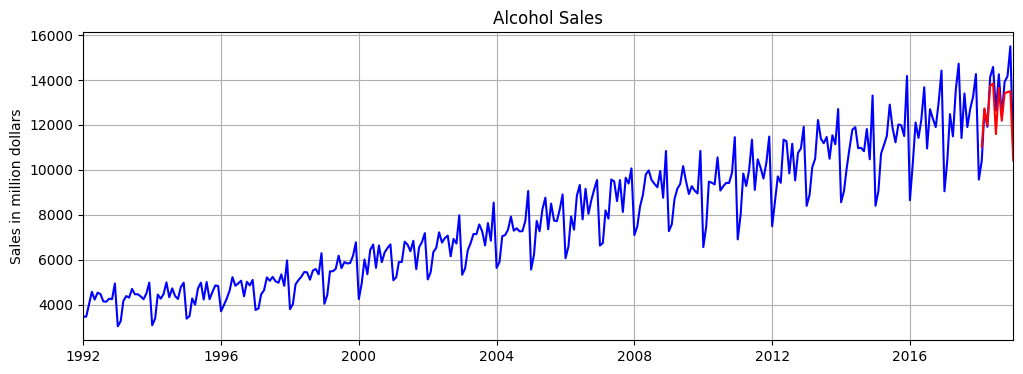

In [61]:
# Plotting

x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['Sales'], color='blue')
plt.plot(x, true_predictions, color='red')
plt.show()

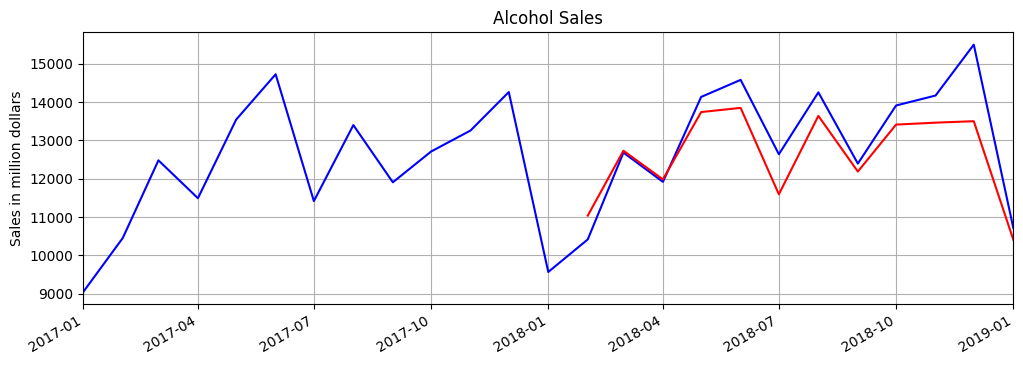

In [62]:
# Zooming the test predictions

fig = plt.figure(figsize=(12, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

plt.plot(df['Sales']['2017-01-01':], color='blue')
plt.plot(x, true_predictions, color='red')
plt.show()